## Setup for data loading

In [1]:
import cv2
import h5py
from tqdm import tqdm   # ref: https://github.com/tqdm/tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import random

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


## Load human detection training data

In [3]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = imgname[8:12]
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)
hf.close()

In [4]:
# Check number of human dectection samples.
nData = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
nData

1607

## Load video data

In [5]:
# Save corresponding clips (takes ~300s)
frame_buffer_n = 7   # how many frames for 3d conv (- n)
frame_every = 3
path = 'videos/'
frames = {}
for iClip in tqdm(bbox):
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames[iClip] = {}
    for iFrame in bbox[iClip]:
        frame_buffer = []
        for iBuffer in range(-(frame_buffer_n-1)*frame_every, 1, frame_every):
        #for iBuffer in range(-frame_buffer_n, frame_buffer_n+1):
            cap.set(1, int(iFrame)+iBuffer)
            ret, frame = cap.read()
            if ret:
                frame_buffer.append(frame)
        frames[iClip][iFrame] = torch.from_numpy(np.stack(frame_buffer))

100%|██████████| 10/10 [05:05<00:00, 30.54s/it]


In [6]:
# print index of frames
for x in range(-(frame_buffer_n-1)*frame_every, 1, frame_every):
    print(x)

-18
-15
-12
-9
-6
-3
0


39 19


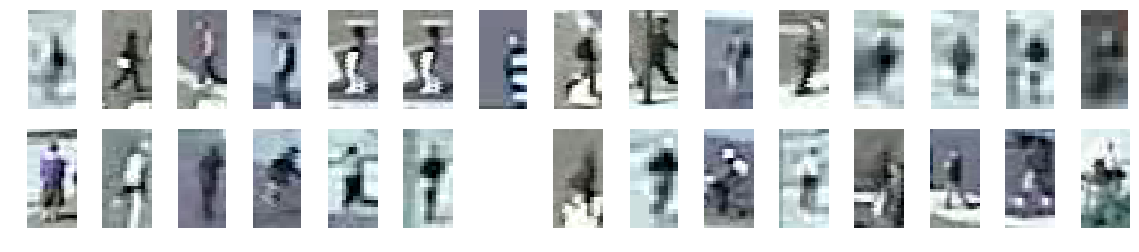

In [7]:
# Random sanity check
fig = plt.figure(figsize=(20,4))
for i in range(30):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    try:
        x,y,w,h = bbox[iClip][iFrame][0]
        ax.imshow(frames[iClip][iFrame][6, y:y+h, x:x+w, :]) # when the pedestrian is at center (here, last)
    except:
        continue
print(h, w)

## Generate map from ground truth

100%|██████████| 10/10 [00:00<00:00, 89.90it/s]


(-0.5, 719.5, 479.5, -0.5)

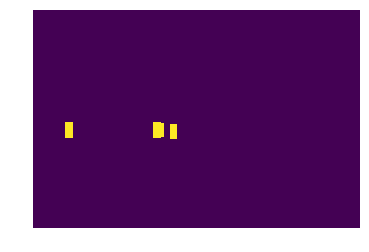

In [23]:
_, w, h, _ = frames['001']['0001'].shape
pedes_map = {}
for iClip in tqdm(bbox):
    pedes_map[iClip] = {}
    for iFrame in bbox[iClip]:
        tmp = np.zeros((w, h))
        for p in bbox[iClip][iFrame]:
            try:
                x, y, dx, dy = p
                tmp[y:y+dy, x:x+dx] = 1
            except:
                continue
        pedes_map[iClip][iFrame] = tmp
plt.imshow(pedes_map[iClip][iFrame])
plt.axis('off')

(-0.5, 719.5, 479.5, -0.5)

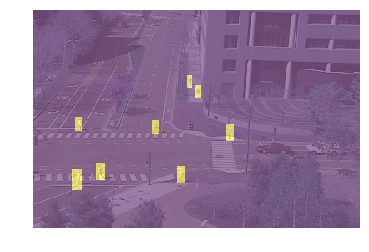

In [176]:
plt.imshow(frames['001']['0201'][-1, :, :], alpha=0.5)
plt.imshow(pedes_map['001']['0201'], alpha=0.5)
plt.axis('off')

## Training data with (3d; stack of) images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 

1) crop/zero-padding the image to equal size, or 

2) scale the image.

In [24]:
frames[iClip][iFrame].shape

torch.Size([7, 480, 720, 3])

100%|██████████| 10/10 [00:00<00:00, 47.69it/s]


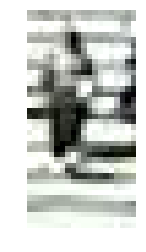

In [187]:
# Generating train data. All images are cropped to (40, 20).
# True data
h_0 = 40
w_0 = 20
X_sample = torch.zeros(nData,3,frame_buffer_n,h_0,w_0)
y_sample = torch.zeros(nData, )
i = 0
for iClip in tqdm(bbox):
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x -= int((w-w_0)/2)
                y -= int((h-h_0)/2)
                if i == 100:
                    plt.imshow(frames[iClip][iFrame][-1, y:y+h_0, x:x+w_0,:])
                    plt.axis('off')
                data = frames[iClip][iFrame][:, y:y+h_0, x:x+w_0, :].to(dtype=torch.float32)
                X_sample[i,:,:,:,:] = torch.unsqueeze(data.permute(3,0,1,2), 0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

In [188]:
X_sample.shape, y_sample.shape

(torch.Size([1571, 3, 7, 40, 20]), torch.Size([1571]))

100%|██████████| 4713/4713 [04:38<00:00, 16.91it/s]


4504


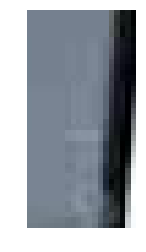

In [189]:
# False data are randomly sampled from images.
# thres_sample: this index decide whether to include or not when randomly sampled image partically include pedestrian
thres_sample = 0.1
n = int(3.0 * X_sample.shape[0])
false_num = 0
for i in tqdm(range(1 * n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    if (np.sum(pedes_map[iClip][iFrame][y:y+h_0, x:x+w_0])/(h_0 * w_0)) < thres_sample:
        try:
            if i == 100:
                plt.imshow(frames[iClip][iFrame][-1, y:y+h_0, x:x+w_0, :])
                plt.axis('off')
            data = frames[iClip][iFrame][:, y:y+h_0, x:x+w_0, :].to(dtype=torch.float32)
            X_sample = torch.cat((X_sample,torch.unsqueeze(data.permute(3,0,1,2),0)),0)
            y_sample = torch.cat((y_sample, torch.zeros(1)))
            false_num += 1
        except:
            continue
print(false_num)

In [190]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

In [191]:
X_sample.shape, X_train.shape 

(torch.Size([6075, 3, 7, 40, 20]), torch.Size([4860, 3, 7, 40, 20]))

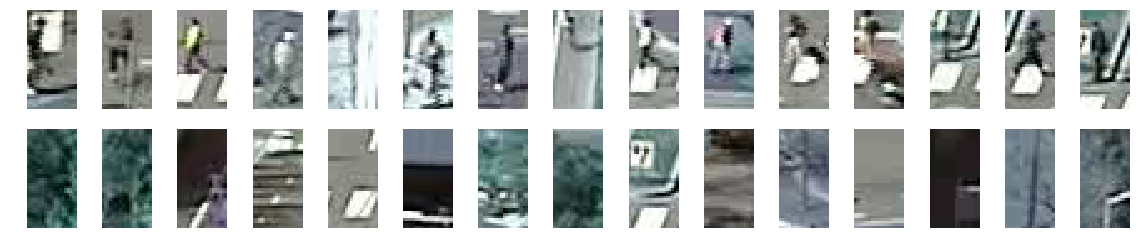

In [192]:
fig = plt.figure(figsize=(20,4))
for i in range(15):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    n = int(random.random()*1300)
    ax.imshow(X_sample[n][:, -1, :, :].permute(1,2,0).to(dtype=torch.uint8))

for i in range(15):
    ax = fig.add_subplot(2,15,i+16)
    ax.axis('off')
    n = int(random.random()*800)+1600
    ax.imshow(X_sample[n][:, -1, :, :].permute(1,2,0).to(dtype=torch.uint8))

In [193]:
def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = X.shape[0]
        for i in range(N):
            xi = X[i].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yi = y[i].unsqueeze(0).to(device=device, dtype=torch.long)
            scores = model(xi)
            _, preds = scores.max(1)
            #print(preds)
            num_correct += (preds == yi).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        
def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    for e in tqdm(range(epochs)):
        for i in range(int(N/epochs)):
            Xt = X[t].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yt = y[t].unsqueeze(0).to(device=device, dtype=torch.long)
            
            scores = model(Xt)
            loss = F.cross_entropy(scores, yt)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            t += 1
            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(X_train, y_train, model)
                check_accuracy(X_val, y_val, model)
                print()

In [194]:
# Train CNN
#model = nn.Sequential(
#    nn.Conv3d(3, 32, 3, padding=1, stride=1),
#    nn.BatchNorm3d(32),
#    nn.MaxPool3d((1, 2, 2)),
#    nn.Conv3d(32, 32, 3, padding=1, stride=1),
#    nn.BatchNorm3d(32),
#    nn.MaxPool3d((1, 2, 2)),
#    nn.Conv3d(32, 16, 3, padding=1, stride=1),
#    nn.LeakyReLU(),
#    Flatten(),
#    nn.Linear(16*7*h_0/4*w_0/4, 30),
#    nn.LeakyReLU(),
#    nn.Linear(30, 2),
#)
#optimizer = optim.Adam(model.parameters(), lr=4e-5, betas=(0.9, 0.999))
#train_model(X_train, y_train, model, optimizer, epochs=10)

### ~ 93.57 % accuracy when N(true):N(false)=1:1

In [195]:
# Train 3D-CNN
model = nn.Sequential(
    nn.Conv3d(3, 32, 3, padding=1, stride=1),
    nn.BatchNorm3d(32),
    nn.MaxPool3d((1, 2, 2)),
    #nn.LeakyReLU(),
    nn.Conv3d(32, 32, 3, padding=1, stride=1),
    nn.BatchNorm3d(32),
    nn.MaxPool3d((1, 4, 2)),
    #nn.LeakyReLU(), ###
    #nn.Dropout(),
    nn.Conv3d(32, 16, 3, padding=1, stride=1),
    nn.LeakyReLU(),
    Flatten(),
    nn.Linear(16*7*h_0/8*w_0/4, 30),
    nn.LeakyReLU(),
    nn.Linear(30, 2),
)
optimizer = optim.Adam(model.parameters(), lr=4e-5, betas=(0.9, 0.999))
train_model(X_train, y_train, model, optimizer, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration 100, loss = 1.3602
Got 3606 / 4860 correct (74.20)
Got 898 / 1215 correct (73.91)

Iteration 200, loss = 0.0432
Got 3608 / 4860 correct (74.24)
Got 898 / 1215 correct (73.91)

Iteration 300, loss = 0.1052
Got 3606 / 4860 correct (74.20)
Got 898 / 1215 correct (73.91)

Iteration 400, loss = 0.0153
Got 3790 / 4860 correct (77.98)
Got 939 / 1215 correct (77.28)



 10%|█         | 1/10 [00:30<04:36, 30.68s/it]

Iteration 500, loss = 0.0089
Got 4260 / 4860 correct (87.65)
Got 1067 / 1215 correct (87.82)

Iteration 600, loss = 0.0465
Got 4221 / 4860 correct (86.85)
Got 1056 / 1215 correct (86.91)

Iteration 700, loss = 0.0143
Got 4156 / 4860 correct (85.51)
Got 1021 / 1215 correct (84.03)

Iteration 800, loss = 0.6365
Got 4266 / 4860 correct (87.78)
Got 1050 / 1215 correct (86.42)

Iteration 900, loss = 0.0047
Got 4241 / 4860 correct (87.26)
Got 1055 / 1215 correct (86.83)



 20%|██        | 2/10 [01:08<04:32, 34.08s/it]

Iteration 1000, loss = 0.0260
Got 4354 / 4860 correct (89.59)
Got 1086 / 1215 correct (89.38)

Iteration 1100, loss = 2.4738
Got 4336 / 4860 correct (89.22)
Got 1072 / 1215 correct (88.23)

Iteration 1200, loss = 1.7745
Got 4356 / 4860 correct (89.63)
Got 1083 / 1215 correct (89.14)

Iteration 1300, loss = 0.3954
Got 4420 / 4860 correct (90.95)
Got 1097 / 1215 correct (90.29)

Iteration 1400, loss = 0.1163
Got 4453 / 4860 correct (91.63)
Got 1104 / 1215 correct (90.86)



 30%|███       | 3/10 [01:45<04:05, 35.14s/it]

Iteration 1500, loss = 0.0085
Got 4432 / 4860 correct (91.19)
Got 1102 / 1215 correct (90.70)

Iteration 1600, loss = 0.0026
Got 4462 / 4860 correct (91.81)
Got 1103 / 1215 correct (90.78)

Iteration 1700, loss = 1.5586
Got 4371 / 4860 correct (89.94)
Got 1085 / 1215 correct (89.30)

Iteration 1800, loss = 0.0085
Got 4515 / 4860 correct (92.90)
Got 1108 / 1215 correct (91.19)

Iteration 1900, loss = 0.0048
Got 4553 / 4860 correct (93.68)


 40%|████      | 4/10 [02:22<03:34, 35.73s/it]

Got 1119 / 1215 correct (92.10)

Iteration 2000, loss = 0.0008
Got 4492 / 4860 correct (92.43)
Got 1117 / 1215 correct (91.93)

Iteration 2100, loss = 0.0003
Got 4512 / 4860 correct (92.84)
Got 1117 / 1215 correct (91.93)

Iteration 2200, loss = 0.0076
Got 4562 / 4860 correct (93.87)
Got 1122 / 1215 correct (92.35)

Iteration 2300, loss = 0.0061
Got 4572 / 4860 correct (94.07)
Got 1120 / 1215 correct (92.18)

Iteration 2400, loss = 0.1104
Got 4584 / 4860 correct (94.32)


 50%|█████     | 5/10 [03:00<03:00, 36.10s/it]

Got 1124 / 1215 correct (92.51)

Iteration 2500, loss = 0.0000
Got 4603 / 4860 correct (94.71)
Got 1131 / 1215 correct (93.09)

Iteration 2600, loss = 0.0189
Got 4427 / 4860 correct (91.09)
Got 1105 / 1215 correct (90.95)

Iteration 2700, loss = 0.0006
Got 4444 / 4860 correct (91.44)
Got 1101 / 1215 correct (90.62)

Iteration 2800, loss = 0.0209
Got 4569 / 4860 correct (94.01)
Got 1130 / 1215 correct (93.00)

Iteration 2900, loss = 0.0051
Got 4633 / 4860 correct (95.33)


 60%|██████    | 6/10 [03:37<02:25, 36.32s/it]

Got 1135 / 1215 correct (93.42)

Iteration 3000, loss = 0.0014
Got 4626 / 4860 correct (95.19)
Got 1134 / 1215 correct (93.33)

Iteration 3100, loss = 0.2242
Got 4646 / 4860 correct (95.60)
Got 1137 / 1215 correct (93.58)

Iteration 3200, loss = 0.0038
Got 4639 / 4860 correct (95.45)
Got 1134 / 1215 correct (93.33)

Iteration 3300, loss = 1.0053
Got 4407 / 4860 correct (90.68)
Got 1101 / 1215 correct (90.62)

Iteration 3400, loss = 0.0059
Got 4581 / 4860 correct (94.26)


 70%|███████   | 7/10 [04:15<01:49, 36.50s/it]

Got 1139 / 1215 correct (93.74)

Iteration 3500, loss = 0.4642
Got 4646 / 4860 correct (95.60)
Got 1144 / 1215 correct (94.16)

Iteration 3600, loss = 0.0114
Got 4661 / 4860 correct (95.91)
Got 1154 / 1215 correct (94.98)

Iteration 3700, loss = 0.0216
Got 4665 / 4860 correct (95.99)
Got 1146 / 1215 correct (94.32)

Iteration 3800, loss = 0.0014
Got 4640 / 4860 correct (95.47)
Got 1133 / 1215 correct (93.25)



 80%|████████  | 8/10 [04:46<01:11, 35.75s/it]

Iteration 3900, loss = 0.2555
Got 4649 / 4860 correct (95.66)
Got 1144 / 1215 correct (94.16)

Iteration 4000, loss = 0.0071
Got 4682 / 4860 correct (96.34)
Got 1146 / 1215 correct (94.32)

Iteration 4100, loss = 0.0051
Got 4554 / 4860 correct (93.70)
Got 1112 / 1215 correct (91.52)

Iteration 4200, loss = 0.0006
Got 4678 / 4860 correct (96.26)
Got 1151 / 1215 correct (94.73)

Iteration 4300, loss = 0.0139
Got 4681 / 4860 correct (96.32)
Got 1154 / 1215 correct (94.98)



 90%|█████████ | 9/10 [05:23<00:35, 35.96s/it]

Iteration 4400, loss = 0.0365
Got 4670 / 4860 correct (96.09)
Got 1150 / 1215 correct (94.65)

Iteration 4500, loss = 0.0007
Got 4668 / 4860 correct (96.05)
Got 1144 / 1215 correct (94.16)

Iteration 4600, loss = 0.0010
Got 4641 / 4860 correct (95.49)
Got 1134 / 1215 correct (93.33)

Iteration 4700, loss = 0.0005
Got 4678 / 4860 correct (96.26)
Got 1150 / 1215 correct (94.65)

Iteration 4800, loss = 0.0125
Got 4695 / 4860 correct (96.60)
Got 1162 / 1215 correct (95.64)



100%|██████████| 10/10 [06:00<00:00, 36.10s/it]


In [196]:
filters = []
for param in model.parameters():
    filters.append(torch.from_numpy(param.cpu().detach().numpy()).to(dtype=torch.float32))
for f in range(len(filters)):
    print(filters[f].shape)
print(len(filters))

torch.Size([32, 3, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([16, 32, 3, 3, 3])
torch.Size([16])
torch.Size([30, 2800])
torch.Size([30])
torch.Size([2, 30])
torch.Size([2])
14


In [197]:
def predict_ped(inputs, filters):
    z = F.conv3d(inputs, filters[0], bias=filters[1], padding=1, stride=1)
    z = F.instance_norm(z, filters[2], filters[3])
    z = F.max_pool3d(z, (1, 2, 2))
    z = F.conv3d(z, filters[4], bias=filters[5], padding=1, stride=1)
    z = F.instance_norm(z, filters[6], filters[7])
    z = F.max_pool3d(z, (1, 2, 2))
    z = F.conv3d(z, filters[8], bias=filters[9], padding=1, stride=1)
    z = F.leaky_relu(z)
    tmp = torch.reshape(filters[10], (30, 16, 7, 5, 5))
    z = F.conv3d(z, tmp, bias=filters[11], padding=(0, 2, 2), stride=1)
    z = F.leaky_relu(z)
    z = torch.mm(filters[12], torch.reshape(z, (30, -1)))
    z = torch.reshape(z, (2, 120, 180))
    z = z[1, :, :] - z[0, :, :]
    return z

(-0.5, 179.5, 119.5, -0.5)

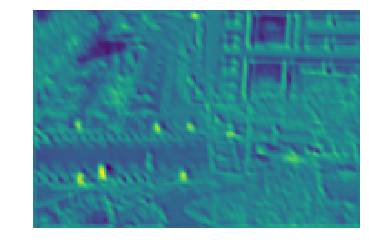

In [198]:
# Test w/ one example
inputs = torch.from_numpy(np.array(frames['001']['0201'].permute(3, 0, 1, 2).unsqueeze(0))).to(dtype=torch.float32)
z1 = predict_ped(inputs, filters)
plt.imshow(z1)
plt.axis('off')

100%|██████████| 10/10 [21:47<00:00, 130.70s/it]


(-0.5, 179.5, 119.5, -0.5)

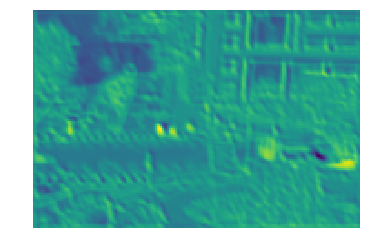

In [199]:
pedes_map_pred = {}
for iClip in tqdm(bbox):
    pedes_map_pred[iClip] = {}
    for iFrame in bbox[iClip]:
        inputs = torch.from_numpy(np.array(frames[iClip][iFrame].permute(3, 0, 1, 2).unsqueeze(0))).to(dtype=torch.float32)
        pedes_map_pred[iClip][iFrame] = predict_ped(inputs, filters)
plt.imshow(pedes_map_pred[iClip][iFrame])
plt.axis('off')

100%|██████████| 5/5 [00:00<00:00, 14.90it/s]


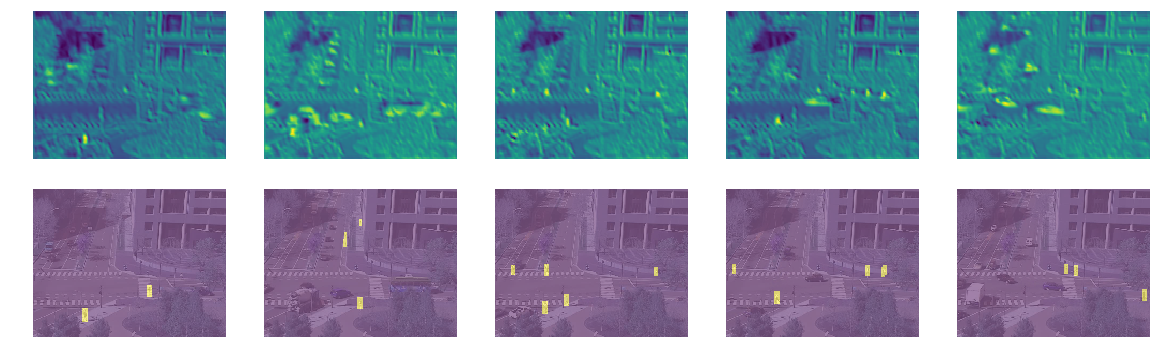

In [205]:
n = 5
fig = plt.figure(figsize=(20,6))
for i in tqdm(range(n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    # Prefig.add_subplotp by our 3D-CNN model
    ax = fig.add_subplot(2, n, i+1)
    ax.imshow(pedes_map_pred[iClip][iFrame], aspect='auto')
    ax.axis('off')
    # CoiClipare with ground truth
    ax = fig.add_subplot(2, n, n+i+1)
    ax.imshow(frames[iClip][iFrame][-1, :, :], aspect='auto', alpha=0.5)
    ax.imshow(pedes_map[iClip][iFrame], aspect='auto', alpha=0.5)
    ax.axis('off')

## Quantify the prediction